# Natural Language Processing Project

>Goals:
- Build a dataset of Github repositories' readme text
- Explore the text of the readme's and find connections to programming language
- Build a classification ML model that predicts the programming language used in a repo based on readme content. 

In [1]:
import numpy as np
import pandas as pd
import json
import re
import warnings
warnings.filterwarnings("ignore")

from prepare import add_columns, split_repo_data
from explore import word_string, word_freq, word_counts, word_cloud
from explore import ngrams, plot_ngrams
import seaborn as sns
import matplotlib.pyplot as plt

Prepare module loaded.


---
## Acquire

In [2]:
# raw data
df = pd.read_json('repos.json')

In [3]:
# summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 598
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  599 non-null    object
 1   repo      599 non-null    object
 2   content   599 non-null    object
dtypes: object(3)
memory usage: 18.7+ KB


In [4]:
df.head()

,language,repo,content
0,JavaScript,facebook/react,React · \nReact is a JavaScript library for...
1,JavaScript,d3/d3,D3: Data-Driven Documents\n\nD3 (or D3.js) is ...
2,JavaScript,vuejs/vue,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...
3,JavaScript,axios/axios,axios\n\n\n\n\n\n\n\n\nPromise based HTTP clie...
4,JavaScript,facebook/create-react-app,Create React App \n\nCreate React apps with n...


In [5]:
# how many of each language
df.language.value_counts()

JavaScript    300
Python        299
Name: language, dtype: int64

In [6]:
# number of unique repos
df.repo.nunique()

581

<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li> Data acquired using the BeautifulSoup library </li>
<li> Used helper functions to get requests to the first 30 search pages of most starred repos for Javascript and Python. </li>
 <li>Used helper function to parse HTML to find certain elements that contained the <i>programming language</i>, <i>repo-sub url</i>, and the <i>readme content</i> for each repo among said pages and saved to a DataFrame. Stored as a json file locally for reproduction.</li>
</div>

---
## Prepare

In [7]:
# prepared data
df = pd.read_json('repos_clean.json').reset_index().drop(columns='index')

In [8]:
# adds list of words column and length of cleaned doc
df = add_columns(df)

In [9]:
# prepped data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   language    581 non-null    object
 1   repo        581 non-null    object
 2   content     581 non-null    object
 3   stemmed     581 non-null    object
 4   lemmatized  581 non-null    object
 5   clean       581 non-null    object
 6   words       581 non-null    object
 7   doc_length  581 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 36.4+ KB


In [10]:
# split the data
train, validate, test = split_repo_data(df)

In [11]:
print(train.language.value_counts(), '\n')
print(validate.language.value_counts(), '\n')
print(test.language.value_counts())
train.head(3)

JavaScript    180
Python        168
Name: language, dtype: int64 

JavaScript    60
Python        56
Name: language, dtype: int64 

JavaScript    60
Python        57
Name: language, dtype: int64


,language,clean,words,doc_length
277,Python,welcome streamlit fastest way build share data...,"[welcome, streamlit, fastest, way, build, shar...",202
97,JavaScript,translation espaol deutsch portugus trke add f...,"[translation, espaol, deutsch, portugus, trke,...",633
501,Python,plotlypy latest release user forum pypi downlo...,"[plotlypy, latest, release, user, forum, pypi,...",399


<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li>Readme content is normalized, tokenized, stemmed, lemmatized, and stopwords are removed to produce "clean" content.</li>
    <li>Duplicate repos are removed and 2 columns are created</li>
    <li>The data is split into train, validate, and, test; stratifying on the programming language.</li>
</div>

---
## Explore

> **What's the proportion of each language in our data?**

In [12]:
# total counts and proportions of each language 
labels = pd.concat([train.language.value_counts(), 
                    train.language.value_counts(normalize=True)], axis=1) 
labels.columns = ['n', 'percent']
labels

,n,percent
JavaScript,180,0.517241
Python,168,0.482759


> **What are the most common words in READMEs?**

In [13]:
# used helper functions from explore.py
js_words, py_words, all_words = word_string(train)
js_freq, py_freq, all_freq = word_freq(js_words, py_words, all_words)
word_counts = word_counts(js_freq, py_freq)

In [14]:
# more refined list that frequents one language as opposed to the other
print('20 Most Common Words')
refined_wordcounts = word_counts[(word_counts.prop_js <= .40) | (word_counts.prop_js >= .60)]
refined_wordcounts.sort_values(by=['all', 'prop_js'], ascending=False).head(20)

20 Most Common Words


,js,py,all,prop_js
python,32,1374,1406,0.022760
function,1032,373,1405,0.734520
data,384,830,1214,0.316310
react,1205,6,1211,0.995045
native,1051,27,1078,0.974954
default,670,363,1033,0.648596
library,330,606,936,0.352564
return,660,254,914,0.722101
object,638,265,903,0.706534
new,588,305,893,0.658455


> **Does the length of the README vary by programming language?**

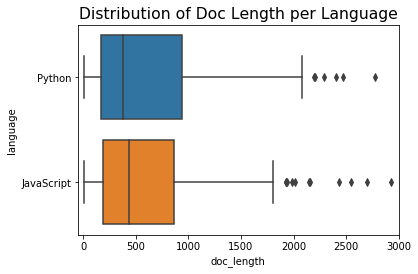

In [15]:
sns.boxplot(y=train.language, x=train.doc_length, orient="h")
plt.xlim(-50, 3000)
plt.rc('font', size=13)
plt.title('Distribution of Doc Length per Language')
plt.tight_layout()

In [16]:
# descriptive statistics for each languages' document length
train.groupby('language').doc_length.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
JavaScript,180.0,935.266667,1530.272370,11.0,187.75,436.5,860.5,10505.0
Python,168.0,915.589286,1570.565409,3.0,171.25,382.0,940.0,10538.0


> **Do different programming languages use a different number of unique words?**

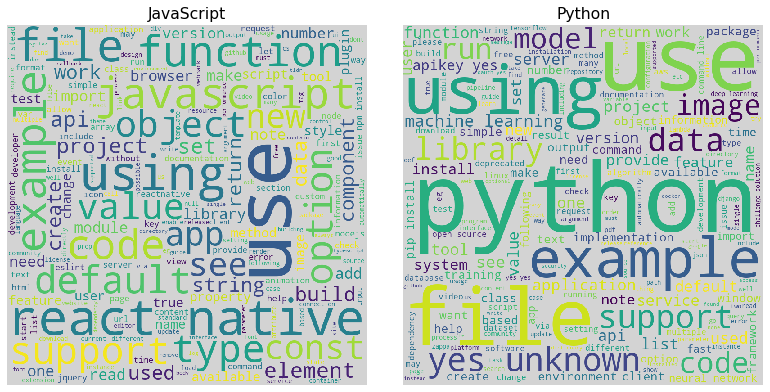

In [17]:
word_cloud(js_words, py_words)

>**What are the highest frequencies of word combinations?** *ie. ngrams*

In [18]:
# bigrams and trigrams for each language
js_bigrams, py_bigrams = ngrams(js_words, py_words, 2)
js_trigrams, py_trigrams = ngrams(js_words, py_words, 3)

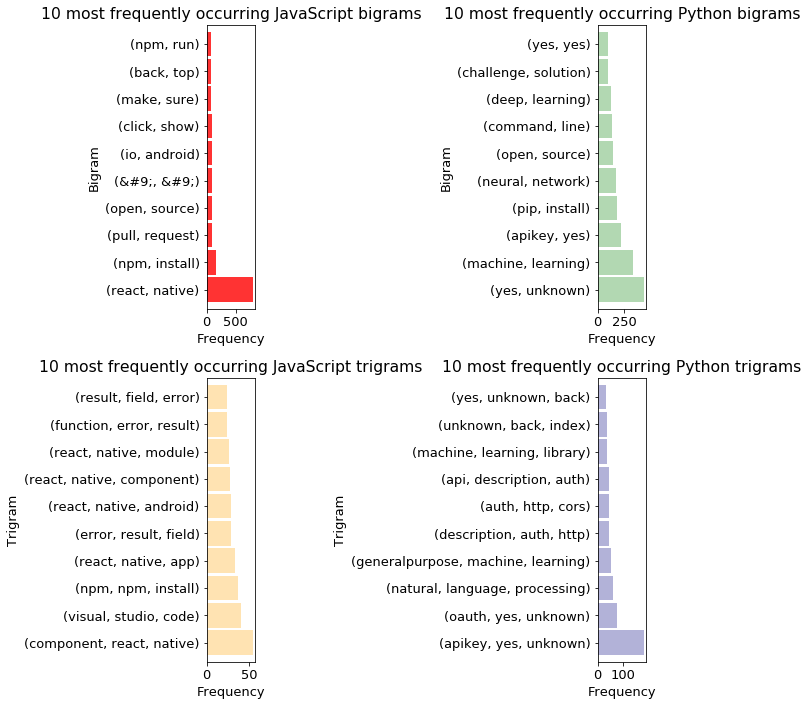

In [19]:
plot_ngrams(js_bigrams, py_bigrams, js_trigrams, py_trigrams)

<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li>The distribution of JavaScript and Python data is nearly 1:1</li>
    <li>Words counts with a distribution of between 40-60% are likely to be useless. Words on both ends of those tails will be more significant in classifying language in the modeling section </li>
    <li>Word combinations may be more useful in classification since the combinations are more unique than individual words. </li>
</div>

---
## Model

#### Establishing a Baseline

In [20]:
train.language.value_counts()

JavaScript    180
Python        168
Name: language, dtype: int64

In [21]:
# Taking the most common result (JavaScript) and making that the baseline prediction.
baseline = round(len(train[train.language == 'JavaScript']) / len(train), 2)

#This is the % accuracy our model would be at if guessing a Readme was JavaScript every single time:
print(f"The baseline model's accuracy is: {baseline:.0%}")

The baseline model's accuracy is: 52%


### Feature Extraction

In [22]:
# Using Bag of Words
X_train_bow, X_validate_bow, X_test_bow = bow_fe(train, validate, test)

# Using Term Frequency - Inverse Document Frequency
X_train_tfidf, X_validate_tfidf, X_test_tfidf = tfidf_fe(train, validate, test)

In [23]:
# set target variable
y_train = train['language']
y_validate = validate['language']
y_test = test['language']

<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li>Using <b>Bag of Words</b> and <b>TF-IDF</b> to assign a numerical value to each word for modeling</li>
    <li>Set X and y variables for computing</li>
    <li>Used helper functions from <i>model.py</i> for cleaner documentation</li>
</div>

---
## Evaluate

In [36]:
from model import bow_fe, tfidf_fe, tfidf_fe_test
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

#### Model 1: Logistic Regression using BOW

In [37]:
# Fit the LogisticRegression on BOW features
lm_bow = LogisticRegression().fit(X_train_bow, y_train)

# Predict the labels
y_pred_bow = lm_bow.predict(X_train_bow)
train['pred_bow'] = y_pred_bow

# Predict for validate
y_pred_bow_v = lm_bow.predict(X_validate_bow)

In [38]:
# Confusion Matrix Train
pd.crosstab(train.language, train.pred_bow)

pred_bow,JavaScript,Python
language,,
JavaScript,180,0
Python,0,168


In [39]:
# Compute the performance metrics
print('TRAIN DATA\n', classification_report(train.language, train.pred_bow))

# Compute the performance metrics for bow features. 
print('VALIDATE DATA\n', classification_report(validate.language, y_pred_bow_v))

TRAIN DATA
               precision    recall  f1-score   support

  JavaScript       1.00      1.00      1.00       180
      Python       1.00      1.00      1.00       168

    accuracy                           1.00       348
   macro avg       1.00      1.00      1.00       348
weighted avg       1.00      1.00      1.00       348

VALIDATE DATA
               precision    recall  f1-score   support

  JavaScript       0.96      0.83      0.89        60
      Python       0.84      0.96      0.90        56

    accuracy                           0.90       116
   macro avg       0.90      0.90      0.90       116
weighted avg       0.90      0.90      0.90       116



#### Model 2: Logistic Regression using TF-IDF

In [40]:
# Fit the LogisticRegression on TFIDF features
lm_tfidf = LogisticRegression().fit(X_train_tfidf, y_train)

# Predict the labels
y_pred_tf = lm_tfidf.predict(X_train_tfidf)
train['pred_tf'] = y_pred_tf

# Predict for validate
y_pred_tf_v = lm_tfidf.predict(X_validate_tfidf)

In [41]:
# Confusion Matrix Train
pd.crosstab(train.language, train.pred_tf)

pred_tf,JavaScript,Python
language,,
JavaScript,180,0
Python,1,167


In [42]:
# Compute the performance metrics 
print('TRAIN DATA\n', classification_report(train.language, train.pred_tf))

# Compute the performance metrics 
print('VALIDATE DATA\n', classification_report(validate.language, y_pred_tf_v))

TRAIN DATA
               precision    recall  f1-score   support

  JavaScript       0.99      1.00      1.00       180
      Python       1.00      0.99      1.00       168

    accuracy                           1.00       348
   macro avg       1.00      1.00      1.00       348
weighted avg       1.00      1.00      1.00       348

VALIDATE DATA
               precision    recall  f1-score   support

  JavaScript       0.96      0.90      0.93        60
      Python       0.90      0.96      0.93        56

    accuracy                           0.93       116
   macro avg       0.93      0.93      0.93       116
weighted avg       0.93      0.93      0.93       116



<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li>TF-IDF Logistic Regression Model performed best</li>
    <li>Going to move forward with this model for testing on unseen data</li>
</div>

#### Test

In [43]:
# Predict for test
y_pred_tf_t = lm_tfidf.predict(X_test_tfidf)

# Compute the performance metrics 
print('TEST DATA\n', classification_report(test.language, y_pred_tf_t))

TEST DATA
               precision    recall  f1-score   support

  JavaScript       0.90      0.88      0.89        60
      Python       0.88      0.89      0.89        57

    accuracy                           0.89       117
   macro avg       0.89      0.89      0.89       117
weighted avg       0.89      0.89      0.89       117



In [44]:
# Confusion Matrix Train
pd.crosstab(test.language, y_pred_tf_t)

col_0,JavaScript,Python
language,,
JavaScript,53,7
Python,6,51


#### More test data

In [45]:
# read in new repo data (unseen) to test model further
test2 = pd.read_json('test_repos_clean.json')

In [46]:
# 200 new data points
test2.shape

(200, 6)

In [47]:
# tfidf 
X_test2 = tfidf_fe_test(train, test2)

# Predict for test 2
y_pred_tf_t2 = lm_tfidf.predict(X_test2)

In [49]:
# Compute the performance metrics 
print('TEST 2 DATA\n', classification_report(test2.language, y_pred_tf_t2))

TEST 2 DATA
               precision    recall  f1-score   support

  JavaScript       0.90      0.94      0.92       100
      Python       0.94      0.90      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [61]:
# Confusion Matrix Train
pd.crosstab(test2.language, y_pred_tf_t2)

col_0,JavaScript,Python
language,,
JavaScript,94,6
Python,10,90


In [67]:
print('Model Performance (baseline: JavaScript)')
results = pd.DataFrame(columns=['accuracy', 'precision', 
                      'recall', 'f1-score'], 
             index=['baseline', 'train', 
                    'validate', 'test_1', 
                    'test_2'], 
             data=[[.52, .00, .00, .00],
                  [1.0, .99, 1.0, 1.0], 
                  [.93, .96, .90, .93], 
                  [.89, .90, .88, .89],
                  [.92, .90, .94, .92]])
results

Model Performance (baseline: JavaScript)


,accuracy,precision,recall,f1-score
baseline,0.52,0.00,0.00,0.00
train,1.00,0.99,1.00,1.00
validate,0.93,0.96,0.90,0.93
test_1,0.89,0.90,0.88,0.89
test_2,0.92,0.90,0.94,0.92


---
## Conclusion